In [ ]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import cv2

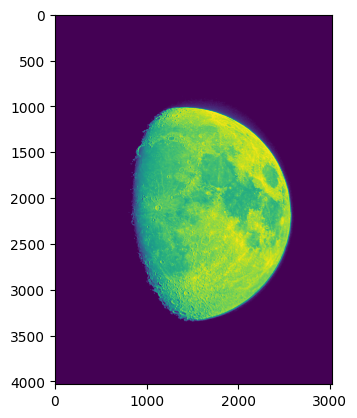

In [ ]:
img=io.imread("/content/gibbous_moon.jp2",as_gray=True)
plt.imshow(img)

In [ ]:
!pip install astropy

In [ ]:
from astropy.convolution import Gaussian2DKernel,interpolate_replace_nans

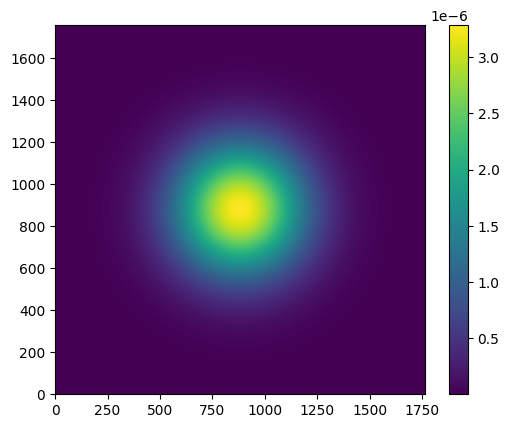

In [ ]:
gaussian_2d_kernel=Gaussian2DKernel(220)
plt.imshow(gaussian_2d_kernel,interpolation='none',origin='lower')
plt.colorbar()
plt.show()

In [ ]:
kernel=Gaussian2DKernel(20)

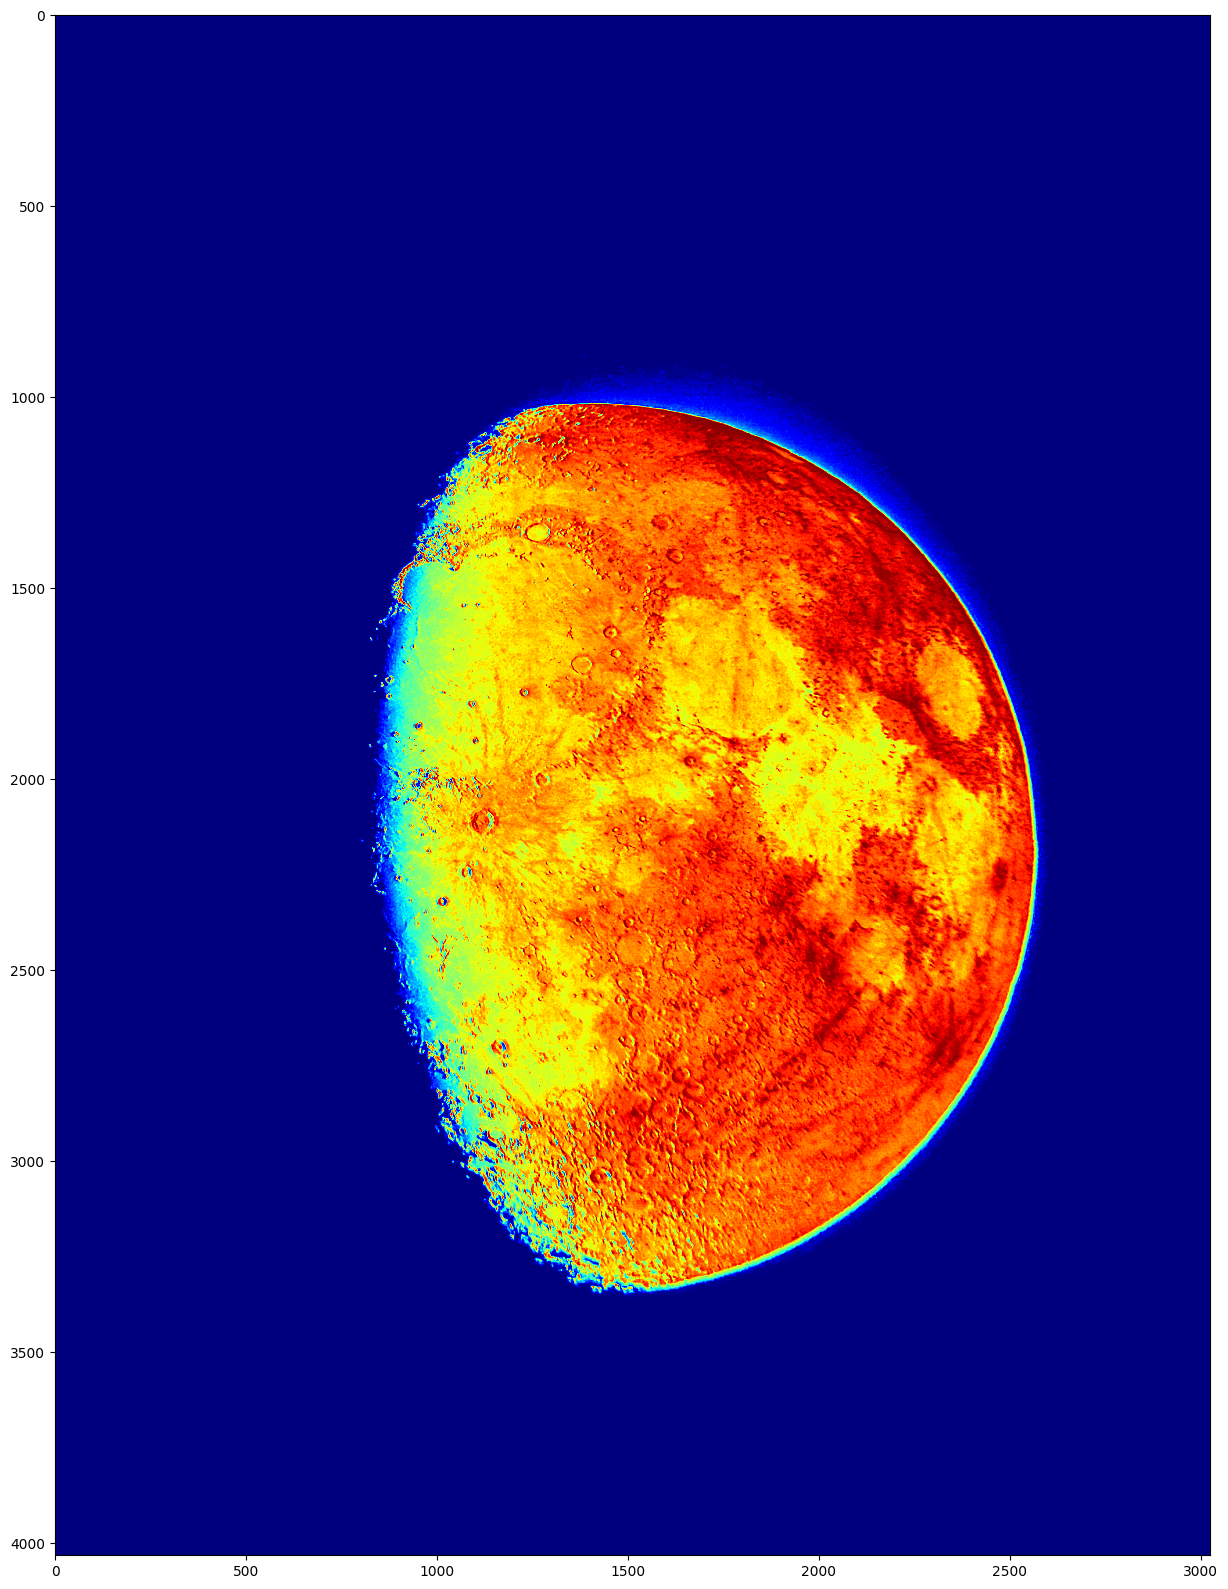

In [ ]:
#we replace NaNs with interpolted data
reconstructed_img=interpolate_replace_nans(img,kernel)
plt.figure(figsize=(18,20))
plt.imshow(reconstructed_img,cmap='jet')

In [ ]:
plt.imsave('moon_gaussian_kernel.png',reconstructed_img)

In [ ]:
from astropy.convolution import Trapezoid1DKernel
trapezoidal_1D_kernel=Trapezoid1DKernel(118,slope=0.3)

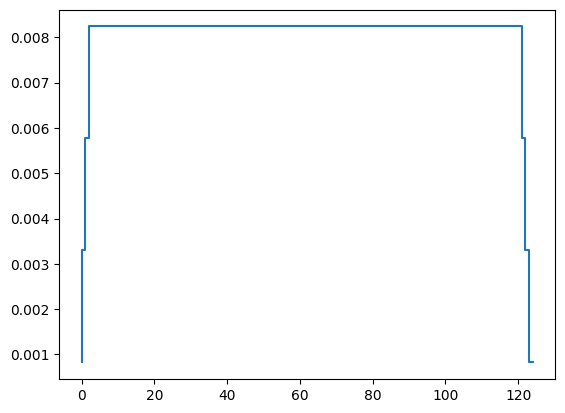

In [ ]:
plt.plot(trapezoidal_1D_kernel,drawstyle='steps')

In [ ]:
reconstructed_img=interpolate_replace_nans(img,trapezoidal_1D_kernel)

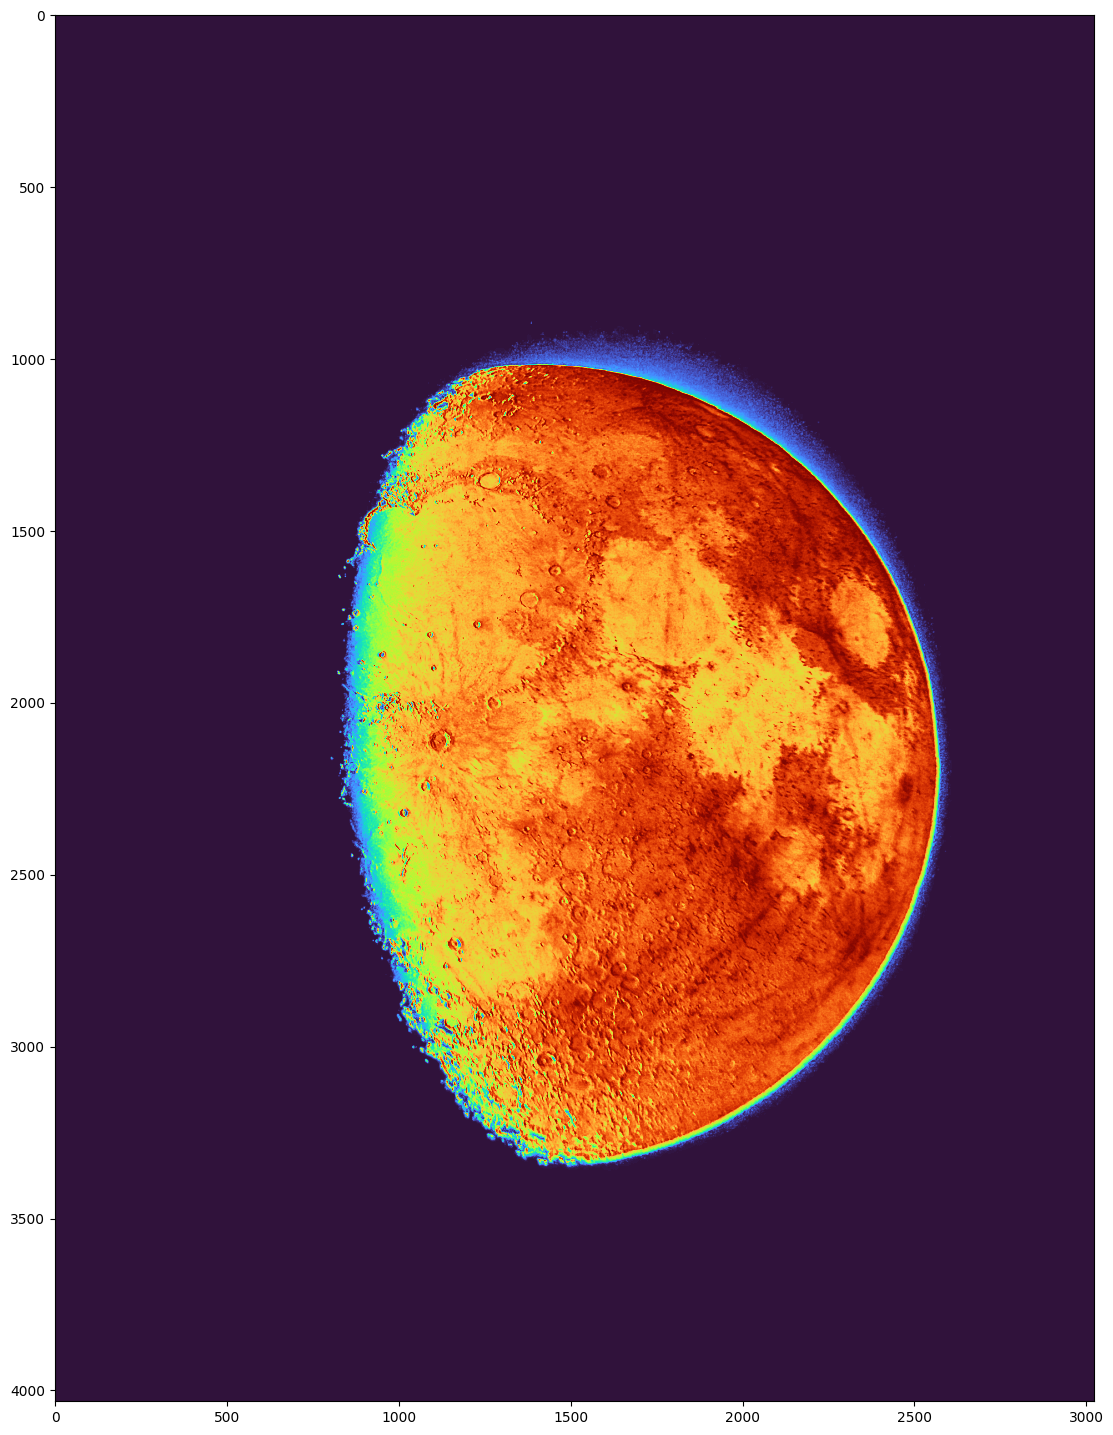

In [ ]:

plt.figure(figsize=(16,18))
plt.imshow(reconstructed_img,cmap='turbo')

In [ ]:
plt.imsave('moon_trapezoidal_kernel.png',reconstructed_img)

## Fourier Transform and Space
Instead Of Doing Denoising using convolution, we Put the Image into Fourier Space first.

In Fourier Space, Central Region represents Low Frequency Components and outer region represents High Frequency

In Fourier Space central region , we Apply a mask and let the High frequency signal pass through which is nothing but edges of images.

In [ ]:
img=cv2.imread("/content/gibbous_moon.jp2",0)

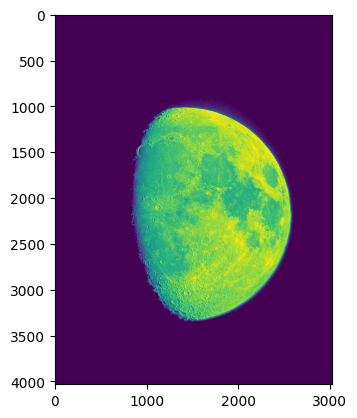

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

(4032, 3024)

In [ ]:
#Develop Fourier Frequency Transform Or Magnitude Spectrum

In [ ]:
#For fft in opencv input image needs to be converted to float32
dft=cv2.dft(np.float32(img),flags=cv2.DFT_COMPLEX_OUTPUT)

In [ ]:
dft.shape

(4032, 3024, 2)

In [ ]:
dft[1].shape

(3024, 2)

In [ ]:
#now we Rearrange the Fourier transform X by shifting the zero-frequency component to the center of the array.
#Otherwise it starts at the top left corner of the image (array)

dft_shift=np.fft.fftshift(dft)

In [ ]:
dft_shift.shape

(4032, 3024, 2)

In [ ]:
##Magnitude of the function is given by 20.log(abs(f))

#For values that are 0 we may end up with indeterminate values for log.
#So we can add 1 to the array to avoid seeing a warning.

magnitude_spectrum=20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))


In [ ]:
magnitude_spectrum.shape

(4032, 3024)

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


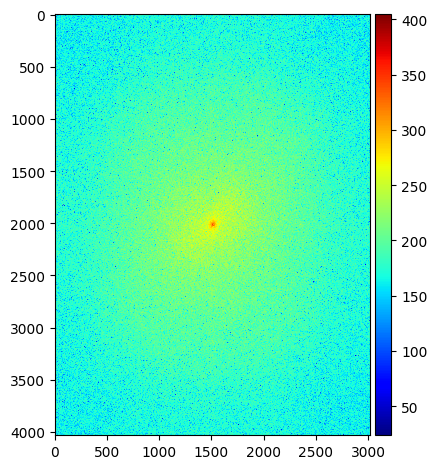

In [ ]:

io.imshow(magnitude_spectrum,cmap='jet')

#Developing a mask
  

In [ ]:
# Circular HPF mask, center circle is 0,
# remaining all ones can be used for edge detection because low frequencies at center are blocked
# And only high frequencies are allowed.
# Edges are high frequency components Amplifies noise.

# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions Can smooth out noise but blurs edges.
rows,cols=img.shape
crow,ccol=int(rows/2),int(cols/2)

mask=np.ones((rows,cols,2),np.uint8)
r=40      #mask radius
center=[crow,ccol]

x,y=np.ogrid[:rows,:cols]


In [ ]:
x.shape

(4032, 1)

In [ ]:
y.shape

(1, 3024)

In [ ]:
print(x)   #x is grid axis

[[   0]
 [   1]
 [   2]
 ...
 [4029]
 [4030]
 [4031]]


In [ ]:
print(y)

[[   0    1    2 ... 3021 3022 3023]]


In [ ]:
#so we have created a grid

In [ ]:
center=[crow,ccol]

In [ ]:
center

[2016, 1512]

In [ ]:
mask_area_component_1=(x-center[0])**2
print('mask_area_component_1: \n',mask_area_component_1)
print('\n')

mask_area_component_2=(y-center[1])**2
print('mask_area_component_2: \n',mask_area_component_2)
print('\n')

mask_sum_component=mask_area_component_1+mask_area_component_2
print("mask_sum_component: \n",mask_sum_component)
print('\n')
print("mask_sum_component_shape: \n",mask_sum_component.shape)

mask_area_component_1: 
 [[4064256]
 [4060225]
 [4056196]
 ...
 [4052169]
 [4056196]
 [4060225]]


mask_area_component_2: 
 [[2286144 2283121 2280100 ... 2277081 2280100 2283121]]


mask_sum_component: 
 [[6350400 6347377 6344356 ... 6341337 6344356 6347377]
 [6346369 6343346 6340325 ... 6337306 6340325 6343346]
 [6342340 6339317 6336296 ... 6333277 6336296 6339317]
 ...
 [6338313 6335290 6332269 ... 6329250 6332269 6335290]
 [6342340 6339317 6336296 ... 6333277 6336296 6339317]
 [6346369 6343346 6340325 ... 6337306 6340325 6343346]]


mask_sum_component_shape: 
 (4032, 3024)


In [ ]:
mask_sum_component[center[0],center[1]]

0

In [ ]:
mask_sum_component_boolean =mask_sum_component <=r*r  # <=1600
print(mask_sum_component_boolean)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
mask_sum_component_boolean[552,600]

False

In [ ]:
mask_sum_component_boolean[590,680]

False

In [ ]:
mask_sum_component_boolean.shape

(4032, 3024)

In [ ]:
mask.shape

(4032, 3024, 2)

In [ ]:
#now we overlap mask and mask_sumcomponent_boolean
# so 0 where True (middle region) and 1 where false (outside region)

mask[mask_sum_component_boolean]=0
print(mask.shape)
print(mask)

(4032, 3024, 2)
[[[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 ...

 [[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]]


In [ ]:
mask[552,600]

array([1, 1], dtype=uint8)

In [ ]:
#now apply mask and inverse dft:
#Multiply fourier transformed image(values) with thr mask values

fshift=dft_shift*mask

In [ ]:
#magnitiude
fshift_mask_mag=20*np.log(cv2.magnitude(fshift[:, :,0],fshift[:,:,1]))


<ipython-input-199-79f4a6dd1675>:2: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag=20*np.log(cv2.magnitude(fshift[:, :,0],fshift[:,:,1]))


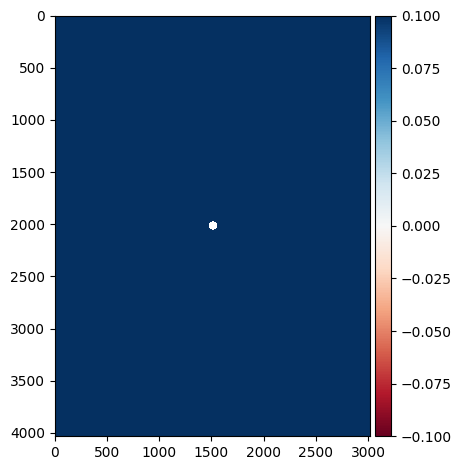

In [ ]:
io.imshow(fshift_mask_mag)

In [ ]:
#the masked image has been created


#inverse dft to get edges of  image

In [ ]:
 #Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)      # Unmasked Pixel Values #discrete fourier transform

#inverse dft
img_back=cv2.idft(f_ishift)
#magnitude
img_back=cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

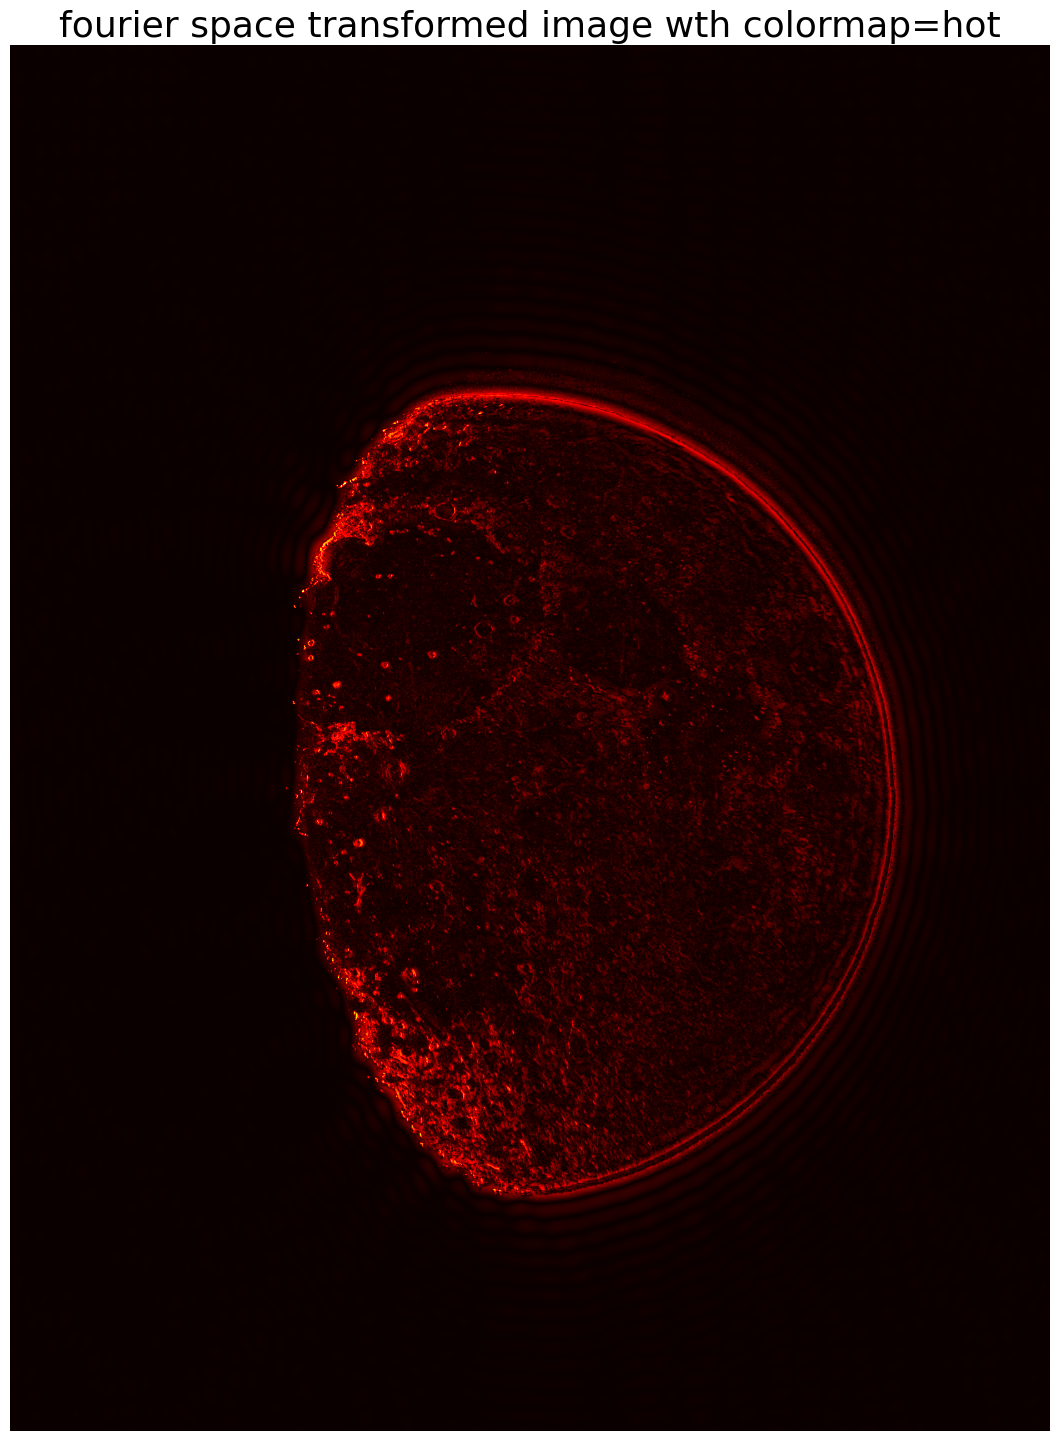

In [ ]:
plt.figure(figsize=(15,18))
plt.imshow(img_back,cmap='hot')
plt.title("fourier space transformed image wth colormap=hot",{'size': 26})
plt.axis("off")

plt.show()

In [ ]:
plt.imsave("dft_edge_moon_hot.png",img_back,cmap='hot')

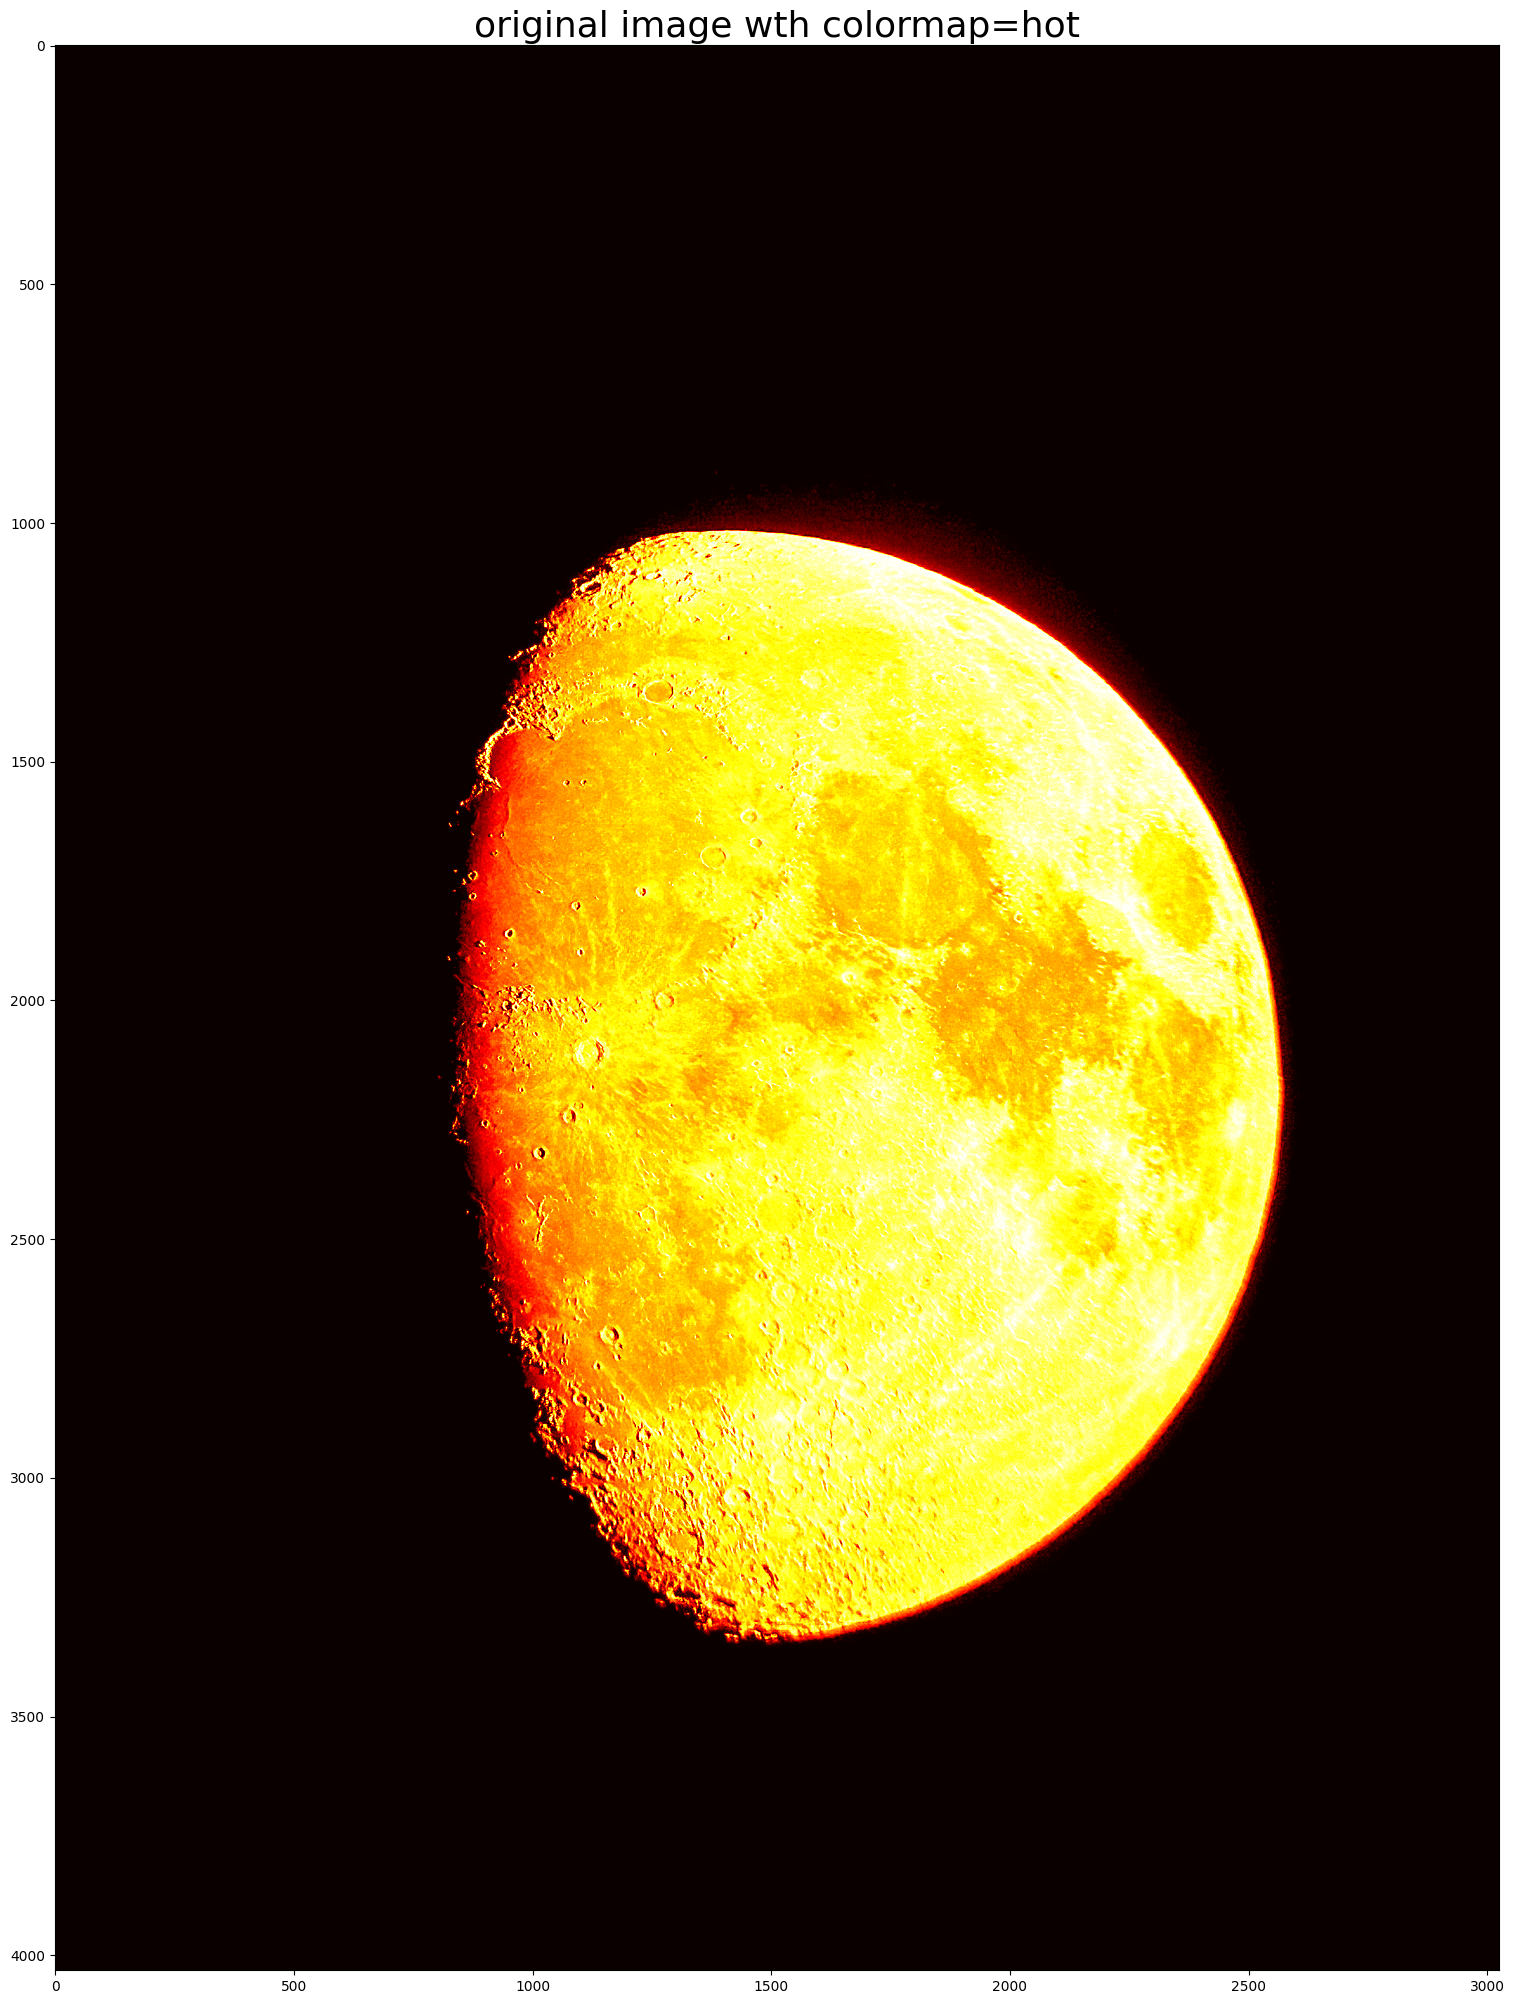

In [ ]:

plt.figure(figsize=(20,25))
plt.imshow(img,cmap='hot',label="original image wth colormap = hot")
# plt.legend(loc=2, prop={'size': 25})
plt.title("original image wth colormap=hot",{'size': 26})
plt.show()
